# AutoML model

In this notebook, we demonstrate how to:
- prepare time series data for training a forecasting model using an automated ML model builder
- Creating an Experiment using an existing Workspace
- Configure AutoML using 'AutoMLConfig'
- Train the model on local compute 
- Explore the engineered features and results
- Configuration and run AutoML for a time-series model with lag and rolling window features
- Run and explore the forecast
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load and temperature data only.

This notebook is based on the energy forecasting notebook provided [here](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.ipynb).

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
np.set_printoptions(precision=2)

# Squash warning messages for cleaner output in the notebook
import warnings
warnings.showwarning = lambda *args, **kwargs: None
warnings.filterwarnings("ignore")

Load the data from csv into a Pandas dataframe. Make sure to first complete the [0_data_setup](../0_data_setup.ipynb) notebook.

In [2]:
import os

file_name = os.path.join('../data', 'energy.parquet')
energy = pd.read_parquet(file_name)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate data as follows:
* November 1, 2014 to December 31, 2014:  **test** set. 
* September 1, 2014 to October 31, 2014:  **validation** set. 
* Everything up to August 31, 2014: **training** set.

In [3]:
valid_start_dt = '2014-08-31 23:59:59'
test_start_dt = '2014-10-31 23:59:59'

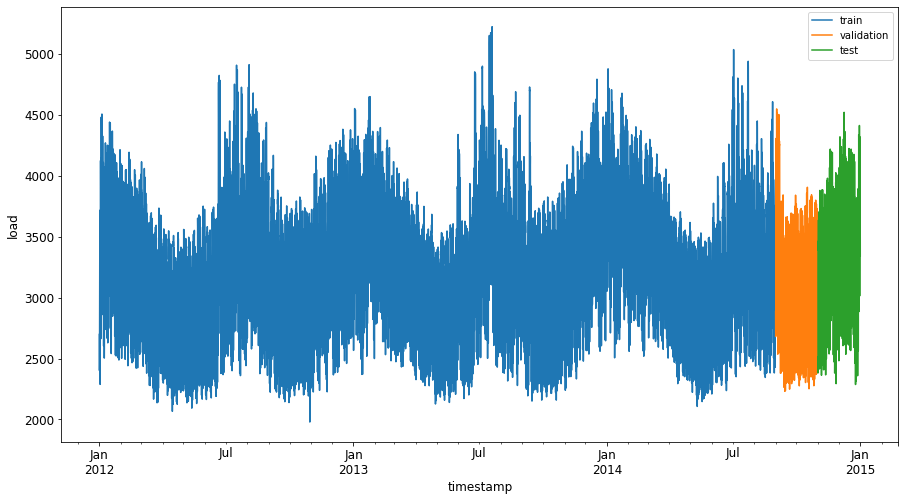

In [4]:
energy[:valid_start_dt][['load']] \
    .rename(columns={'load':'train'}) \
    .join(energy[valid_start_dt:test_start_dt][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']] \
          .rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Data preparation - training set

AutoML takes care of a lot of the details. We simply need to prepare a Pandas DataFrame for each of Train, Test, and Validation.

*HORIZON=1* specifies that we have a forecasting horizon of 1 (*t+1*)

In [5]:
HORIZON = 1

Our data preparation for the training set will involve the following steps:

1. Create a time column from the index
2. Filter the original dataset to include only that time period reserved for the training set
3. Drop rown with missing values 

### 1. Add time column

In [6]:
energy['timestamp'] = energy.index

### 2. Filter the original dataset to include only that time period reserved for each set
Create training, test and validations sets

In [7]:
ds_train = energy[:valid_start_dt].copy()
ds_valid = energy[valid_start_dt:test_start_dt].copy()
ds_test = energy[test_start_dt:].copy()

Verify that the series are continuous.

In [8]:
print(ds_train.tail())
print(ds_valid.head())

                        load  temp           timestamp
2014-08-31 19:00:00 3,969.00 74.67 2014-08-31 19:00:00
2014-08-31 20:00:00 3,869.00 74.00 2014-08-31 20:00:00
2014-08-31 21:00:00 3,643.00 73.00 2014-08-31 21:00:00
2014-08-31 22:00:00 3,365.00 72.00 2014-08-31 22:00:00
2014-08-31 23:00:00 3,097.00 71.33 2014-08-31 23:00:00
                        load  temp           timestamp
2014-09-01 00:00:00 2,886.00 71.00 2014-09-01 00:00:00
2014-09-01 01:00:00 2,768.00 70.00 2014-09-01 01:00:00
2014-09-01 02:00:00 2,699.00 69.33 2014-09-01 02:00:00
2014-09-01 03:00:00 2,681.00 68.33 2014-09-01 03:00:00
2014-09-01 04:00:00 2,690.00 68.33 2014-09-01 04:00:00


### 3. Discard any samples with missing values
We will discard these.

In [9]:
ds_train.dropna(how="any", inplace=True)
ds_valid.dropna(how="any", inplace=True)
ds_test.dropna(how="any", inplace=True)

We now have data of shape:

In [10]:
print('Train data shape:', ds_train.shape)
print('Valid data shape:', ds_valid.shape)
print('Test data shape:', ds_test.shape)

Train data shape: (23376, 3)
Valid data shape: (1464, 3)
Test data shape: (1464, 3)


## Set Up AzureML Workspace

As part of the setup you should have access to an Azure ML Workspace. For Automated ML you will need to create an Experiment object, which is a named object in a Workspace used to run experiments.

In [11]:
import azureml.core
from azureml.core import Experiment, Workspace

assert os.path.exists('config.json'), 'Download `config.json` from the Auzre Portal and place in this folder'

ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-forecasting-GEFCom2014'

# Define a project folder where artifacts will be stored
project_folder = './project'
os.makedirs(project_folder, exist_ok=True)

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment_name
output['Project Folder'] = project_folder
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.74
Subscription ID,6fa1b60b-c4be-4966-a446-261a3ad62d42
Workspace,AML2
Resource Group,AML2
Location,southcentralus
Experiment Name,automl-forecasting-GEFCom2014
Project Folder,./project


## Train

Instantiate an AutoMLConfig object. This config defines the settings and data used to run the experiment. We can provide extra configurations within 'automl_settings', for this forecasting task we add the name of the time column and the maximum forecast horizon. See [here](https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl.automlconfig?view=azure-ml-py) for more options.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**blacklist_models**|Models in blacklist won't be used by AutoML. All supported models can be found at [here](https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl.constants.supportedmodels.regression?view=azure-ml-py).|
|**experiment_timeout_minutes**|Maximum amount of time in minutes that the experiment take before it terminates.|
|**training_data**|The training data to be used within the experiment.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross validation splits. Rolling Origin Validation is used to split time-series in a temporally consistent way.|
|**enable_early_stopping**|Flag to enble early termination if the score is not improving in the short term.|\n",
|**time_column_name**|The name of your time column.|
|**max_horizon**|The number of periods out you would like to predict past your training data. Periods are inferred from your data.|

In [12]:
import logging
from azureml.train.automl import AutoMLConfig

#These models are blacklisted for tutorial purposes, remove this for real use cases.                            
blacklist_models = ['ExtremeRandomTrees', 'AutoArima', 'ElasticNet']

automl_config = AutoMLConfig(
    # Data Parameters
    training_data=ds_train,
    validation_data=ds_valid,
    time_column_name='timestamp',
    label_column_name='load',
    # Forecasting Parameters
    task='forecasting',
    max_horizon=HORIZON,
    primary_metric='normalized_root_mean_squared_error',
    # AutoML Settings
    enable_early_stopping=True,
    blacklist_models=blacklist_models,
    experiment_timeout_minutes=5,
    verbosity=logging.ERROR,
    path=project_folder,
)

### Submit the job

Call the submit method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while. 

The optional `show_output=True` causes currently running iterations to print to the console.

In [13]:
%%time

run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_4725b7e9-85f2-4641-8fcb-39aef4cf0e86
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:00:13       0.0481    0.0481
         1   StandardScalerWrapper LightGBM               

The `run` object contains a link to the experiment in the AzureML Workspace.

In [14]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-forecasting-GEFCom2014,AutoML_4725b7e9-85f2-4641-8fcb-39aef4cf0e86,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


### Retrieve the Best Model
Below we select the best model from all the training iterations using the `get_output` method.

In [15]:
best_run, fitted_model = run.get_output()
#fitted_model.steps

## Analysis
Below we take a look at the model produced

### Featurization
You can access the engineered feature names generated in time-series featurization

In [16]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['temp',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### View featurization summary
You can also see what featurization steps were performed on different raw features in the user data. For each input field in the user data, the following information is displayed:

- Raw field name
- Number of engineered features formed out of this raw field
- Type detected
- If the feature was dropped
- List of feature transformations for the raw field

In [17]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,No,2,temp,"[MeanImputer, ImputationMarker]",Numeric
1,No,11,timestamp,"[DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer]",DateTime


## Forecasting
Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data.

### Forecast Function
For forecasting, we will use the forecast function instead of the predict function. There are two reasons for this.

We need to pass the recent values of the target variable y, whereas the scikit-compatible predict function only takes the non-target variables 'test'. In our case, the test data immediately follows the training data, and we fill the target variable with NaN. The NaN serves as a question mark for the forecaster to fill with the actuals. Using the forecast function will produce forecasts using the shortest possible forecast horizon. The last time at which a definite (non-NaN) value is seen is the forecast origin - the last time when the value of the target is known.

Using the predict method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use.

In [18]:
# First, we remove the target values from the test set:
X_test = ds_test.copy()
y_test = X_test.pop('load').values

# The forecast origin will be at the beginning of the first forecast period.
# (Which is the same time as the end of the last training period.)
y_query = np.empty_like(y_test)
y_query.fill(np.nan)

# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test, y_query)

It is useful to look at how the inputs were transformed to create the predictions

In [19]:
X_trans.head()

,,temp,temp_WASNULL,year,half,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timestamp,_automl_dummy_grain_col,,,,,,,,,,,,,,
2014-11-01 00:00:00,_automl_dummy_grain_col,38.33,0,2014,2,4,11,1,0,0,0,5,32,44,2526.88
2014-11-01 01:00:00,_automl_dummy_grain_col,37.33,0,2014,2,4,11,1,1,0,1,5,32,44,2443.50
2014-11-01 02:00:00,_automl_dummy_grain_col,36.33,0,2014,2,4,11,1,2,0,2,5,32,44,2412.73
2014-11-01 03:00:00,_automl_dummy_grain_col,36.33,0,2014,2,4,11,1,3,0,3,5,32,44,2405.64
2014-11-01 04:00:00,_automl_dummy_grain_col,36.00,0,2014,2,4,11,1,4,0,4,5,32,44,2435.10


### Evaluate
To evaluate the accuracy of the forecast, we'll compare against the actual load values using the mean absolute percentage error (MAPE) metric.

Collect the target and predictions in a dataset

In [20]:
eval_df = ds_test.copy().drop('timestamp', axis=1)
eval_df['prediction'] = y_predictions
eval_df.rename(columns={'load':'actual'}, inplace=True)
eval_df.head()

,actual,temp,prediction
2014-11-01 00:00:00,2514.00,38.33,2526.88
2014-11-01 01:00:00,2434.00,37.33,2443.50
2014-11-01 02:00:00,2390.00,36.33,2412.73
2014-11-01 03:00:00,2382.00,36.33,2405.64
2014-11-01 04:00:00,2419.00,36.00,2435.10


Compute the mean absolute percentage error over all predictions

In [21]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [22]:
print("MAPE: {:.2f}%".format(100* mape(eval_df['prediction'], eval_df['actual'])))

MAPE: 2.91%


Plot the predictions vs the actuals for the first week of the test set

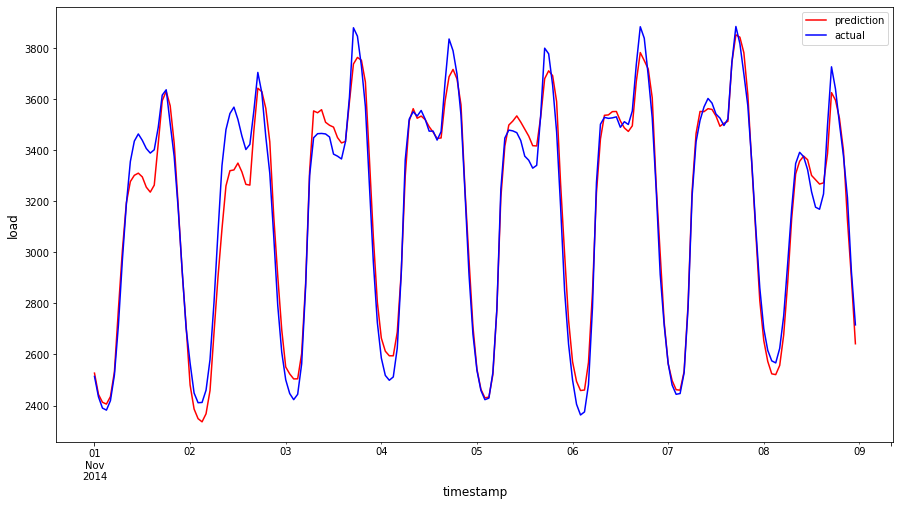

In [23]:
eval_df[:'2014-11-08'] \
    .plot(y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Using lags and rolling window features
Now we will configure the target lags, that is the previous values of the target variables, meaning the prediction is no longer horizon-less. We therefore must still specify the max_horizon that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the max, min and sum features.

This notebook uses the blacklist_models parameter to exclude some models that take a longer time to train on this dataset. You can choose to remove models from the blacklist_models list but you may need to increase the iteration_timeout_minutes parameter value to get results.

In [24]:
# Instead of a separate validation set, we'll use cross_validation to train
ds_train2 = energy[:test_start_dt].copy()

In [25]:
#These models are blacklisted for tutorial purposes, remove this for real use cases.                            
blacklist_models = ['ElasticNet', 'ExtremeRandomTrees', 'GradientBoosting', 'XGBoostRegressor',
                    'ExtremeRandomTrees', 'AutoArima']
max_lag = 12

automl_config = AutoMLConfig(
    # Data Parameters
    training_data=ds_train2,
    #validation_data=ds_valid,
    time_column_name='timestamp',
    label_column_name='load',
    # Parameters for lags and window
    target_lags=max_lag,
    target_rolling_window_size=6,
    # Forecasting Parameters
    task='forecasting',
    max_horizon=HORIZON,
    primary_metric='normalized_root_mean_squared_error',
    # AutoML Settings
    n_cross_validations=5,
    enable_early_stopping=True,
    blacklist_models=blacklist_models,
    experiment_timeout_minutes=10,
    verbosity=logging.ERROR,
    path=project_folder,
)

### Submit the job
We now start a new remote run, this time with lag and rolling window featurization. AutoML applies featurizations in the setup stage, prior to iterating over ML models. The full training set is featurized first, followed by featurization of each of the CV splits. Lag and rolling window features introduce additional complexity, so the run will take longer than in the previous example that lacked these featurizations.

In [26]:
%%time

run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_1e0d28d4-250a-4a22-9cfa-6c2cc17c24a2
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize 

The `run` object contains a link to the experiment in the AzureML Workspace.

In [27]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-forecasting-GEFCom2014,AutoML_1e0d28d4-250a-4a22-9cfa-6c2cc17c24a2,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


### Retrieve the Best Model
Below we select the best model from all the training iterations using the `get_output` method.

In [28]:
best_run, fitted_model = run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('4', Pipeline(memory=None,
       steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_spl...    min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'))]))],
                 flatten_transform=None,
                 weights=[0.2857142857142857, 0.07142857142857142, 0.35714285714285715, 0.07142857142857142, 0.21428571428571427]))]

## Analysis
Below we take a look at the model produced

### Featurization
You can access the engineered feature names generated in time-series featurization

In [29]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['horizon_origin',
 'temp',
 'temp_WASNULL',
 '_automl_target_col_lag12H',
 '_automl_target_col_min_window6H',
 '_automl_target_col_max_window6H',
 '_automl_target_col_mean_window6H',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### View featurization summary
You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

- Raw feature name
- Number of engineered features formed out of this raw feature
- Type detected
- If feature was dropped
- List of feature transformations for the raw feature

In [30]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,No,12,timestamp,"[MaxHorizonFeaturizer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer]",DateTime
1,No,2,temp,"[MeanImputer, ImputationMarker]",Numeric
2,No,4,_automl_target_col,"[Lag, minRollingWindow, maxRollingWindow, meanRollingWindow]",Numeric


## Forecasting
Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data.

### Forecast Function
For forecasting, we will use the forecast function instead of the predict function. There are two reasons for this.

We need to pass the recent values of the target variable y, whereas the scikit-compatible predict function only takes the non-target variables 'test'. In our case, the test data immediately follows the training data, and we fill the target variable with NaN. The NaN serves as a question mark for the forecaster to fill with the actuals. Using the forecast function will produce forecasts using the shortest possible forecast horizon. The last time at which a definite (non-NaN) value is seen is the forecast origin - the last time when the value of the target is known.

Since this model is needs the most recent 12 lag values to make predictions and we set the HORIZON to 1, we can only predict the 13th value in a single call, not the entire test set.

In [31]:
# First, we remove the target values from the test set:
X_test = ds_test.iloc[:13].copy()
y_test = X_test.pop('load').values

# The forecast origin will be at the beginning of the first forecast period.
# (Which is the same time as the end of the last training period.)
y_query = y_test.copy()
y_query[-1] = np.nan

# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test, y_query)

It is useful to look at how the inputs were transformed to create the predictions

In [32]:
X_trans

,,,horizon_origin,temp,temp_WASNULL,_automl_target_col_lag12H,_automl_target_col_min_window6H,_automl_target_col_max_window6H,_automl_target_col_mean_window6H,year,half,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timestamp,_automl_dummy_grain_col,origin,,,,,,,,,,,,,,,,,,,
2014-11-01 00:00:00,_automl_dummy_grain_col,2014-10-31 23:00:00,1,38.33,0,3369.00,2664.00,3466.00,3142.50,2014,2,4,11,1,0,0,0,5,32,44,2514.00
2014-11-01 01:00:00,_automl_dummy_grain_col,2014-11-01 00:00:00,1,37.33,0,3342.00,2514.00,3374.00,2983.83,2014,2,4,11,1,1,0,1,5,32,44,2434.00
2014-11-01 02:00:00,_automl_dummy_grain_col,2014-11-01 01:00:00,1,36.33,0,3287.00,2434.00,3315.00,2827.17,2014,2,4,11,1,2,0,2,5,32,44,2390.00
2014-11-01 03:00:00,_automl_dummy_grain_col,2014-11-01 02:00:00,1,36.33,0,3293.00,2390.00,3142.00,2673.00,2014,2,4,11,1,3,0,3,5,32,44,2382.00
2014-11-01 04:00:00,_automl_dummy_grain_col,2014-11-01 03:00:00,1,36.00,0,3358.00,2382.00,2894.00,2546.33,2014,2,4,11,1,4,0,4,5,32,44,2419.00
2014-11-01 05:00:00,_automl_dummy_grain_col,2014-11-01 04:00:00,1,37.33,0,3437.00,2382.00,2664.00,2467.17,2014,2,4,11,1,5,0,5,5,32,44,2520.00
2014-11-01 06:00:00,_automl_dummy_grain_col,2014-11-01 05:00:00,1,37.33,0,3466.00,2382.00,2520.00,2443.17,2014,2,4,11,1,6,0,6,5,32,44,2714.00
2014-11-01 07:00:00,_automl_dummy_grain_col,2014-11-01 06:00:00,1,38.33,0,3374.00,2382.00,2714.00,2476.50,2014,2,4,11,1,7,0,7,5,32,44,2970.00
2014-11-01 08:00:00,_automl_dummy_grain_col,2014-11-01 07:00:00,1,39.00,0,3315.00,2382.00,2970.00,2565.83,2014,2,4,11,1,8,0,8,5,32,44,3189.00


### Rolling Forecast
In order to predict the test set, we need to do a ***rolling forecast***. For each value we want to forecast, we need to send to the model a window of data covering at least as many historical values as the maximum lag of the target used (12 in this case). The AutoML model will cache the tail of the training sequence to allow lookback for making predictions for the period immediately following the training window, so for the first few predictions we can get away with providing fewer than 12 observations in the call to `predict`.

This is not the most efficient manner to do rolling forecasts, but allows the model to be stateless. Making predictions for the test set takes an order of magnitude longer than for the simple regression model.

In [33]:
from common.progress_bar import update_progress

In [34]:
%%time
predict = np.empty(0)
# for ix in range(max_lag, ds_test.shape[0]):
for ix in range(0, ds_test.shape[0]):
    # First, we remove the target values from the test set:
    X_test = ds_test.iloc[max(0, ix-max_lag):ix+1].copy()
    y_test = X_test.pop('load').values
    # The forecast origin will be the second last item (forecast 1 forward)
    y_query = y_test.copy()
    y_query[-1] = np.nan
    # predict
    y_predictions, X_trans = fitted_model.forecast(X_test, y_query)
    # save
    predict = np.append(predict, y_predictions[-1])
    # Progress update
    if not ix%10:
        update_progress(ix/ds_test.shape[0])
update_progress(1)

Progress: [####################] 100.0%
CPU times: user 4min 38s, sys: 5.29 s, total: 4min 44s
Wall time: 4min 40s


### Evaluate

Collect the target and predictions in a dataset

In [35]:
eval_df = ds_test.copy().drop('timestamp', axis=1)
eval_df['prediction'] = predict
eval_df.rename(columns={'load':'actual'}, inplace=True)
eval_df.head(max_lag+1)

,actual,temp,prediction
2014-11-01 00:00:00,2514.00,38.33,2567.84
2014-11-01 01:00:00,2434.00,37.33,2459.82
2014-11-01 02:00:00,2390.00,36.33,2394.84
2014-11-01 03:00:00,2382.00,36.33,2369.58
2014-11-01 04:00:00,2419.00,36.00,2428.45
2014-11-01 05:00:00,2520.00,37.33,2548.96
2014-11-01 06:00:00,2714.00,37.33,2739.80
2014-11-01 07:00:00,2970.00,38.33,2975.26
2014-11-01 08:00:00,3189.00,39.00,3093.44
2014-11-01 09:00:00,3356.00,41.33,3276.98


Compute the mean absolute percentage error over all predictions

In [36]:
print("MAPE: {:.2f}%".format(100* mape(eval_df['prediction'], eval_df['actual'])))

MAPE: 2.26%


Plot the predictions vs the actuals for the first week of the test set

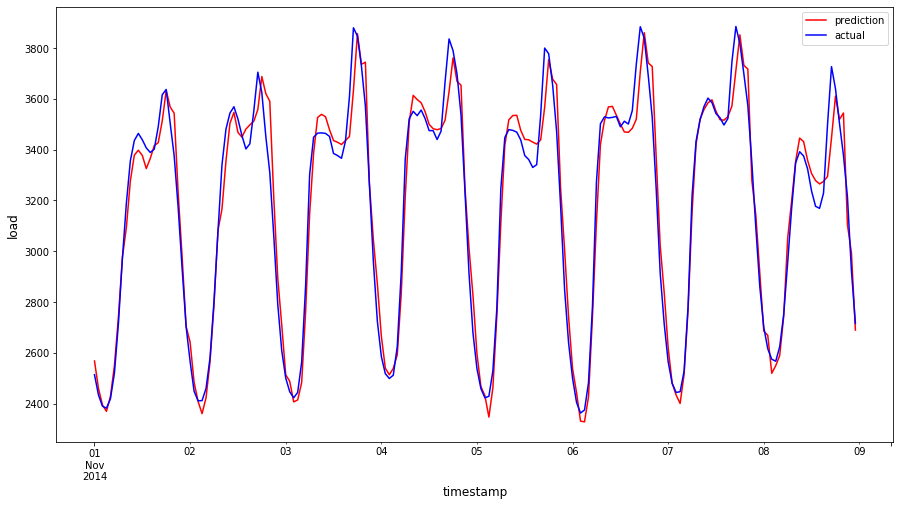

In [37]:
eval_df[:'2014-11-08'] \
    .plot(y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()